<h1 align="center"><a href="https://github.com/sborquez/gerumo/">*</a> GeRUMo - Gamma-ray Events Reconstructor with Uncertain models</h1>

<h2 align="center">Evaluate</h2>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Cta_concept.jpg" width="30%" alt="icon"></img>
</center>



## Setup

The first step is to sync this notebook with Google Drive, and change directory to gerumo repository.

In [1]:
!pip install ctaplot

     |████████████████████████████████| 4.3MB 6.0MB/s 
     |████████████████████████████████| 6.4MB 32.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for ctaplot: filename=ctaplot-0.5.3-cp36-none-any.whl size=4338455 sha256=36b5deea2a0f17bbb9181698d89272b62144df08caee4c58fa36f11f235788e7
  Stored in directory: /root/.cache/pip/wheels/47/7c/aa/c930430d25783f863b9a32ee6a5920d061ba6ac94fad4268e0
Successfully built ctaplot


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/Projects/gerumo"
!ls

/content/drive/My Drive/Projects/gerumo
docs		gerumo	 notebooks  Pipfile.lock  setup.py  train
enviroment.yml	LICENSE  Pipfile    README.md	  tests


## Load Gerumo and extra modules.

In [4]:
from gerumo import *

import logging
import time
from os import path

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
import json
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
import pprint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Angular Reconstruction

## Load Configuration file

In [10]:
config_file = "/content/drive/My Drive/Projects/gerumo/train/config/colab/alt_az/umonna_assembler_colab.json"

print(f"Loading config from: {config_file}")
with open(config_file) as cfg_file:
    config = json.load(cfg_file)

# Model
model_name = config["model_name"]

# Dataset Parameters
output_folder = config["output_folder"]
replace_folder_test = config["replace_folder_test"]
test_events_csv    = config["test_events_csv"]
test_telescope_csv = config["test_telescope_csv"]

# Input and Target Parameters 
telescopes = config["telescopes"]
min_observations = config["min_observations"]
input_image_mode = config["input_image_mode"]
input_image_mask = config["input_image_mask"]
input_features = config["input_features"]
targets = config["targets"]
target_mode = "lineal"
target_shapes = config["target_shapes"]
target_domains = config["target_domains"]
target_resolutions = get_resolution(targets, target_domains, target_shapes)

# Prepare Generator target_mode_config 
target_mode_config = {
    "target_shapes":      tuple([target_shapes[target]      for target in targets]),
    "target_domains":     tuple([target_domains[target]     for target in targets]),
    "target_resolutions": tuple([target_resolutions[target] for target in targets])
}
if target_mode == "probability_map":
    target_sigmas = config["target_sigmas"]
    target_mode_config["target_sigmas"] = tuple([target_sigmas[target] for target in targets])

# Evaluation Parameters
save_plots = config["save_plots"]
save_predictions = config["save_predictions"]

Loading config from: /content/drive/My Drive/Projects/gerumo/train/config/colab/alt_az/umonna_assembler_colab.json


In [11]:
pprint.pprint(config, width=1)

{'input_features': ['x',
                    'y'],
 'input_image_mask': True,
 'input_image_mode': 'simple-shift',
 'min_observations': [0,
                      0,
                      0],
 'model_name': 'UMONNA_V2_ALT_AZ',
 'output_folder': '/content/drive/Shared '
                  'drives/umonna/data/output',
 'replace_folder_test': '/content/drive/Shared '
                        'drives/umonna/data/data/raw/Test',
 'save_plots': True,
 'save_predictions': True,
 'target_domains': {'alt': [1.05,
                            1.382],
                    'az': [-0.52,
                           0.52],
                    'log10_mc_energy': [-2.351,
                                        2.47]},
 'target_mode': 'lineal',
 'target_shapes': {'alt': 81,
                   'az': 81,
                   'log10_mc_energy': 81},
 'target_sigmas': {'alt': 0.002,
                   'az': 0.002,
                   'log10_mc_energy': 0.002},
 'targets': ['alt',
             'az'],
 'telescopes':

## Load Dataset

In [0]:
# Prepare datasets
test_dataset = load_dataset(test_events_csv, test_telescope_csv, replace_folder_test)
test_dataset = aggregate_dataset(test_dataset, az=True, log10_mc_energy=True)
test_dataset = filter_dataset(test_dataset, telescopes, min_observations, target_domains)

# Preprocessing pipes
preprocess_input_pipes = []
preprocess_output_pipes = []

## Data Generator

In [0]:
# Generators
batch_size = 64
telescope_types = [t for t in telescopes.keys() if telescopes[t] is not None]
test_generator = AssemblerGenerator(test_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode=target_mode, 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

# Small test sample
sample_events = np.random.choice(test_dataset.event_unique_id.unique(), 3*256)
sample_dataset = test_dataset[test_dataset.event_unique_id.isin(sample_events)]

sample_generator = AssemblerGenerator(sample_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode="lineal", 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

### Generator sample

In [14]:
# Debug: Check if test dataset is loadable
#for i in tqdm(range(len(test_generator))):
#  _ = test_generator[i]

# Debug: Check if sample dataset is loadable
for i in tqdm(range(len(sample_generator))):
    _ = sample_generator[i]

## Load Models

In [15]:
sst = telescopes["SST1M_DigiCam"]
mst = telescopes["MST_FlashCam"]
lst = telescopes["LST_LSTCam"]
pprint.pprint(telescopes, width=1)

{'LST_LSTCam': '/content/drive/Shared '
               'drives/umonna/data/models/alt_az/small/UMONNA_UNIT_LST_V2_LST_LSTCam_crossentropy_e015_3.9625.h5',
 'MST_FlashCam': '/content/drive/Shared '
                 'drives/umonna/data/models/alt_az/small/UMONNA_UNIT_MST_V2_MST_FlashCam_crossentropy_e014_4.0626.h5',
 'SST1M_DigiCam': '/content/drive/Shared '
                  'drives/umonna/data/models/alt_az/small/UMONNA_UNIT_SST_V2_SST1M_DigiCam_crossentropy_e014_4.5449.h5'}


In [16]:
umonna_assembler = Umonna(sst1m_model_or_path=sst,
                mst_model_or_path=mst,
                lst_model_or_path=lst,
                targets=targets, target_shapes=target_mode_config["target_shapes"],
                target_domains=target_mode_config["target_domains"],
                target_resolutions=target_mode_config["target_resolutions"],
                assembler_mode="normalized_product",
                point_estimation_mode="expected_value"
)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Model Unit Predictions

In [0]:
target_domains_ = target_domains if isinstance(target_domains, dict) else target_domains_
targets = umonna_assembler.targets
models_results = {}

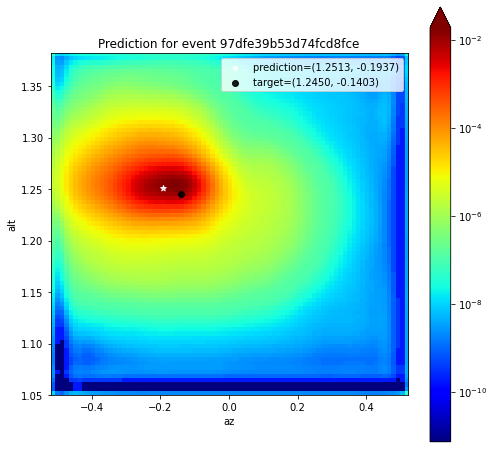

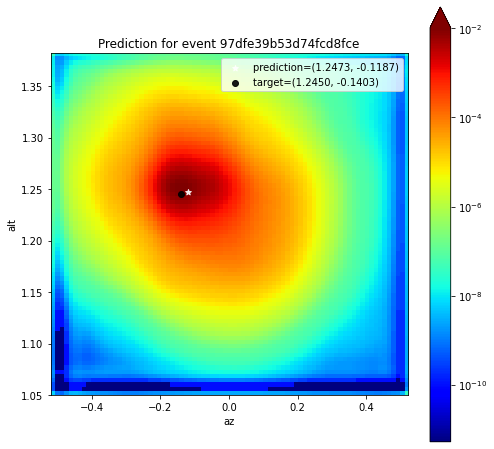

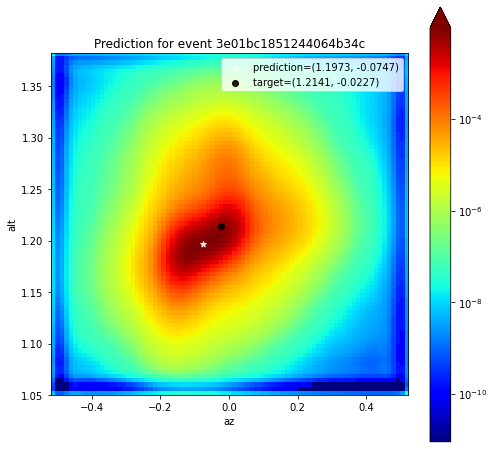

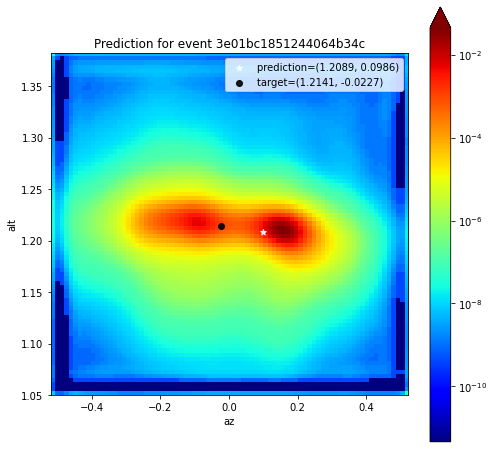

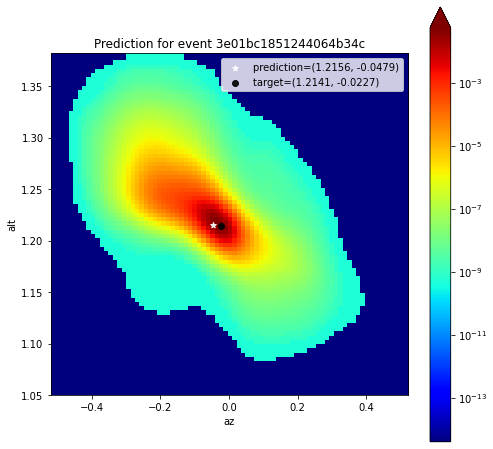

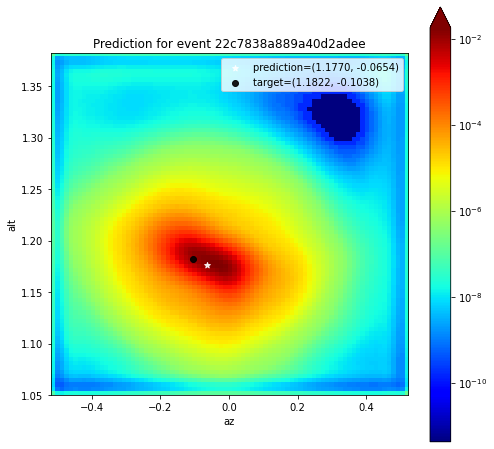

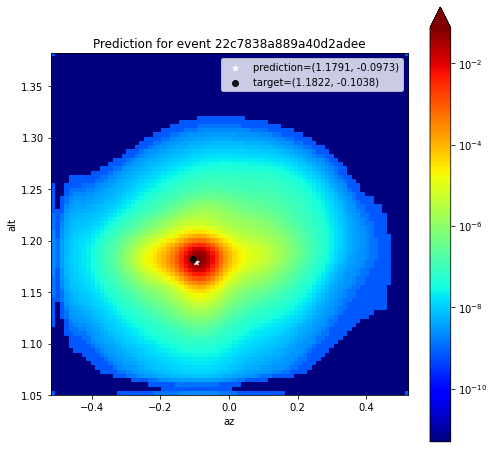

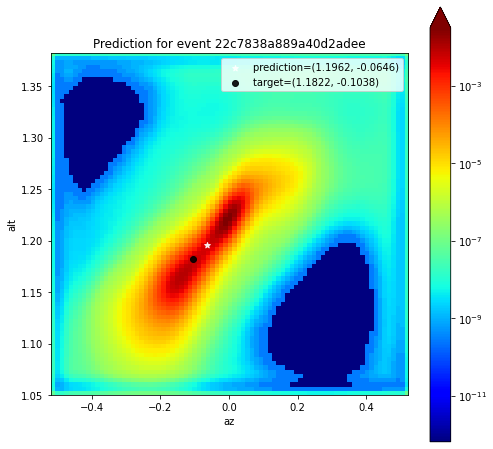

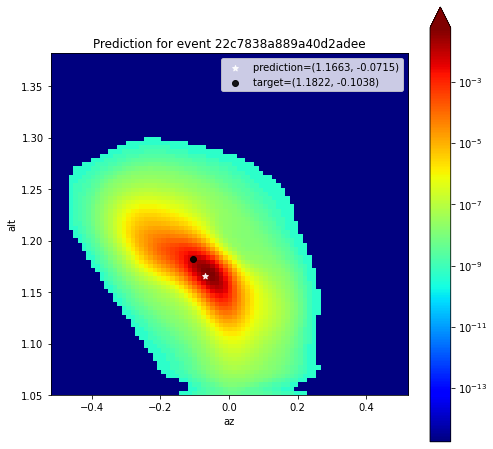

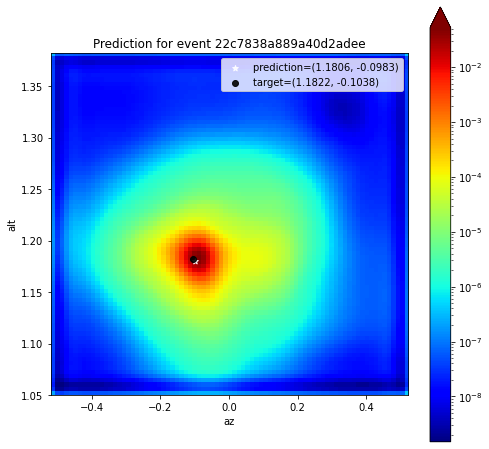

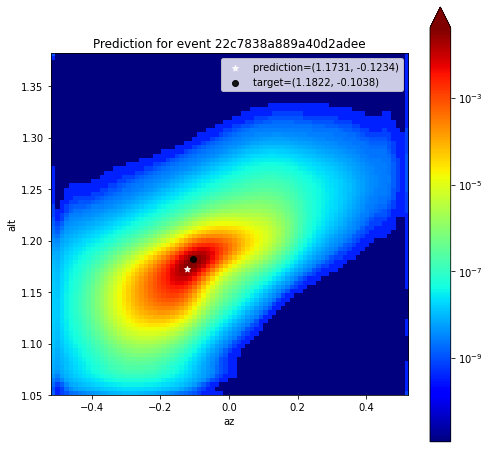

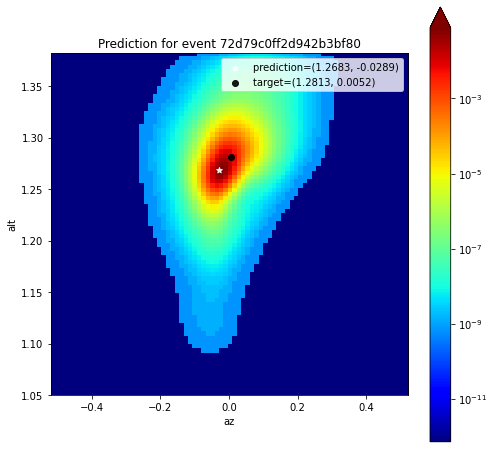

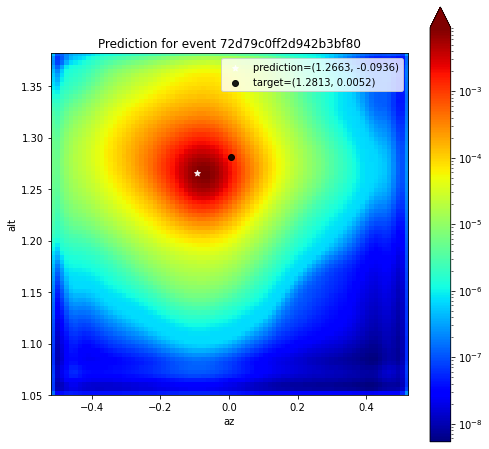

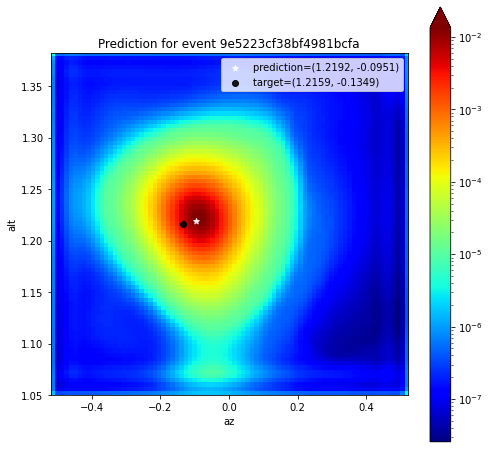

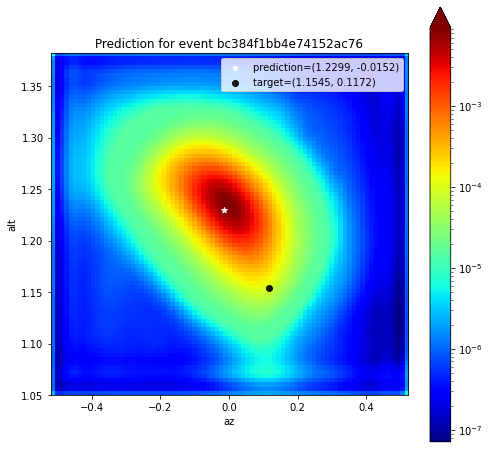

In [18]:
for telescope_i, model in umonna_assembler.models.items():
    display(HTML(f"<h3>{telescope_i}</h3>"))
    # Telescope Sample Dataset
    sample_dataset_telescope = filter_dataset(sample_dataset, [telescope_i], min_observations, target_domains)
    telescope_generator = AssemblerUnitGenerator(sample_dataset_telescope, batch_size, 
                                            input_image_mode=input_image_mode, 
                                            input_image_mask=input_image_mask, 
                                            input_features=input_features,
                                            targets=targets,
                                            target_mode="lineal",
                                            target_mode_config=target_mode_config,
                                            preprocess_input_pipes=preprocess_input_pipes,
                                            preprocess_output_pipes=preprocess_output_pipes,
                                            include_event_id=True,
                                            include_true_energy=True
                                            )
    # Prepare targets points
    targets_values = None
    event_ids = None
    true_energy = None
    predictions = None
    predictions_points = None
    for x, t, meta in tqdm(telescope_generator):
        event_ids = meta["event_id"] if event_ids is None else np.concatenate((event_ids, meta["event_id"]))
        true_energy = meta["true_energy"] if true_energy is None else np.concatenate((true_energy, meta["true_energy"]))
        targets_values = t if targets_values is None else np.concatenate((targets_values, t))
        # Predictions
        p = model.predict(x)
        p_points = umonna_assembler.point_estimation(p)
        predictions = p if predictions is None else  np.concatenate((predictions, p))
        predictions_points = p_points if predictions_points is None else np.concatenate((predictions_points, p_points))

    models_results[telescope_i] = {"predictions": predictions_points, "targets": targets_values, "true_energy": true_energy, "event_ids": event_ids}

    # Show Predictions
    i = 0
    for prediction, prediction_point, target_point, event_id in zip(predictions, predictions_points, targets_values, event_ids):
        plot_assembler_prediction(prediction, prediction_point, targets, umonna_assembler.target_domains, umonna_assembler.target_resolutions, event_id, target_point)
        i+=1
        if i == 5: break

## Model Unit Evaluation


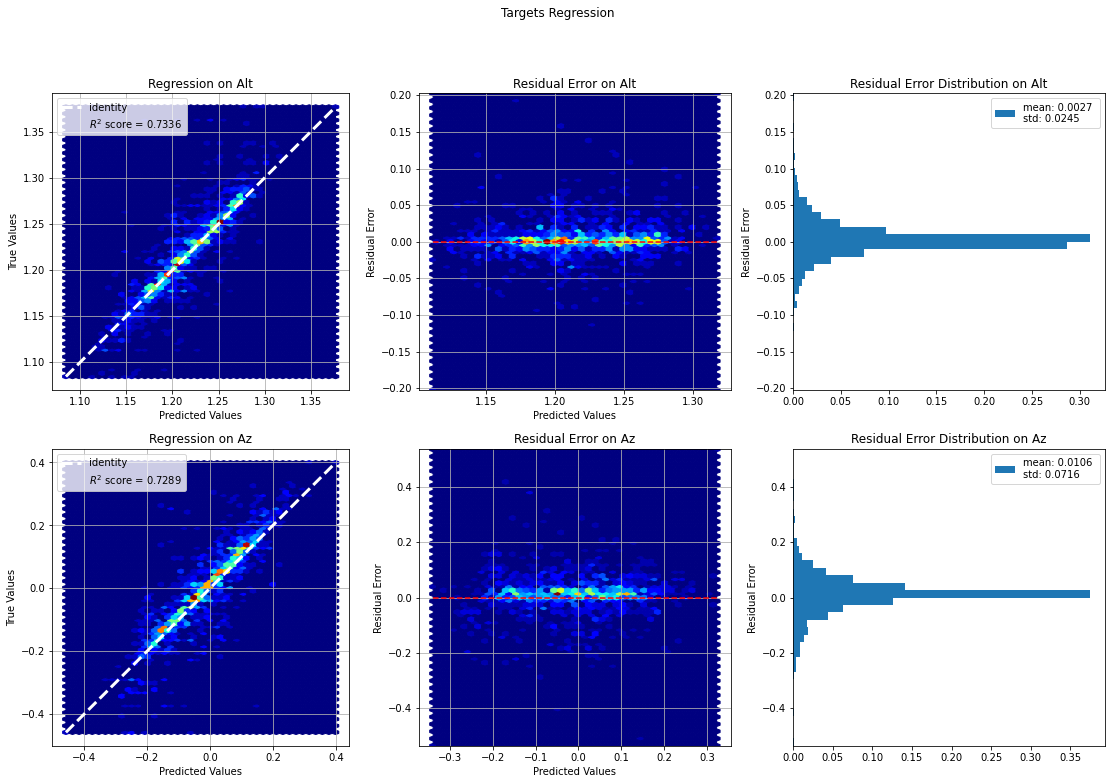

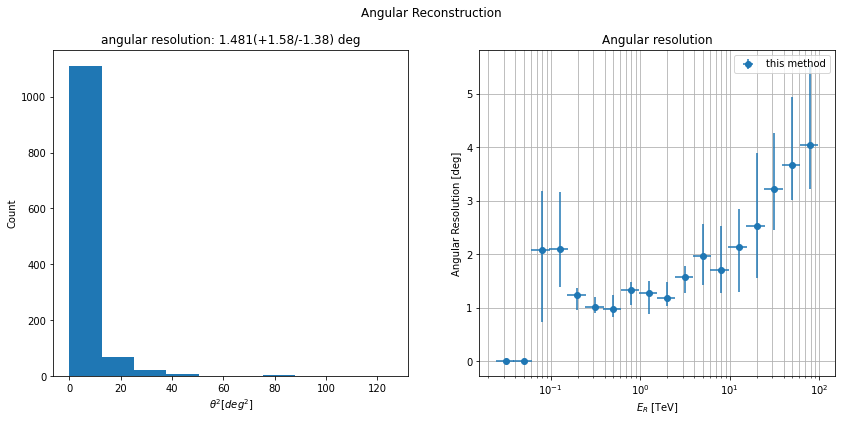

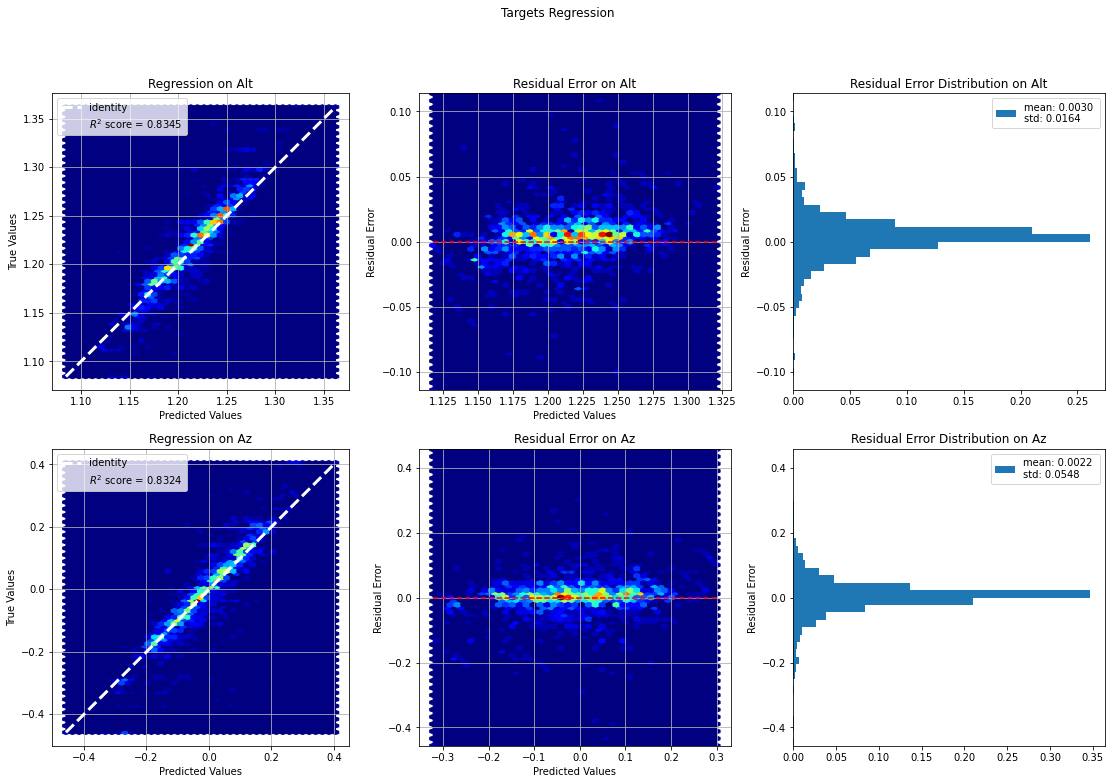

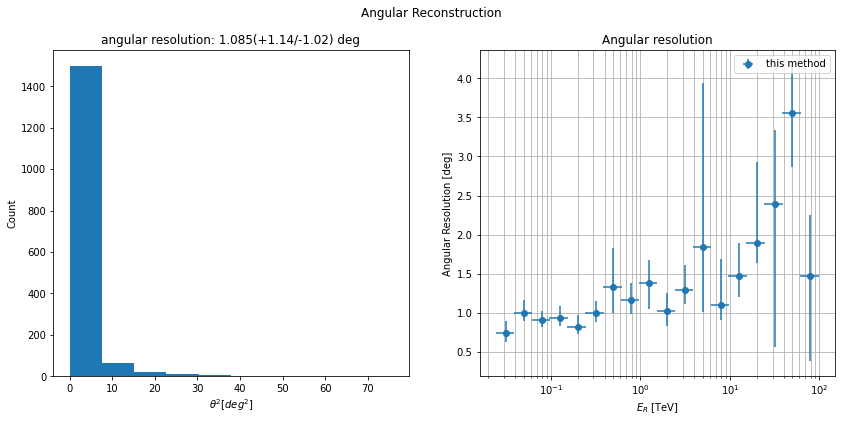

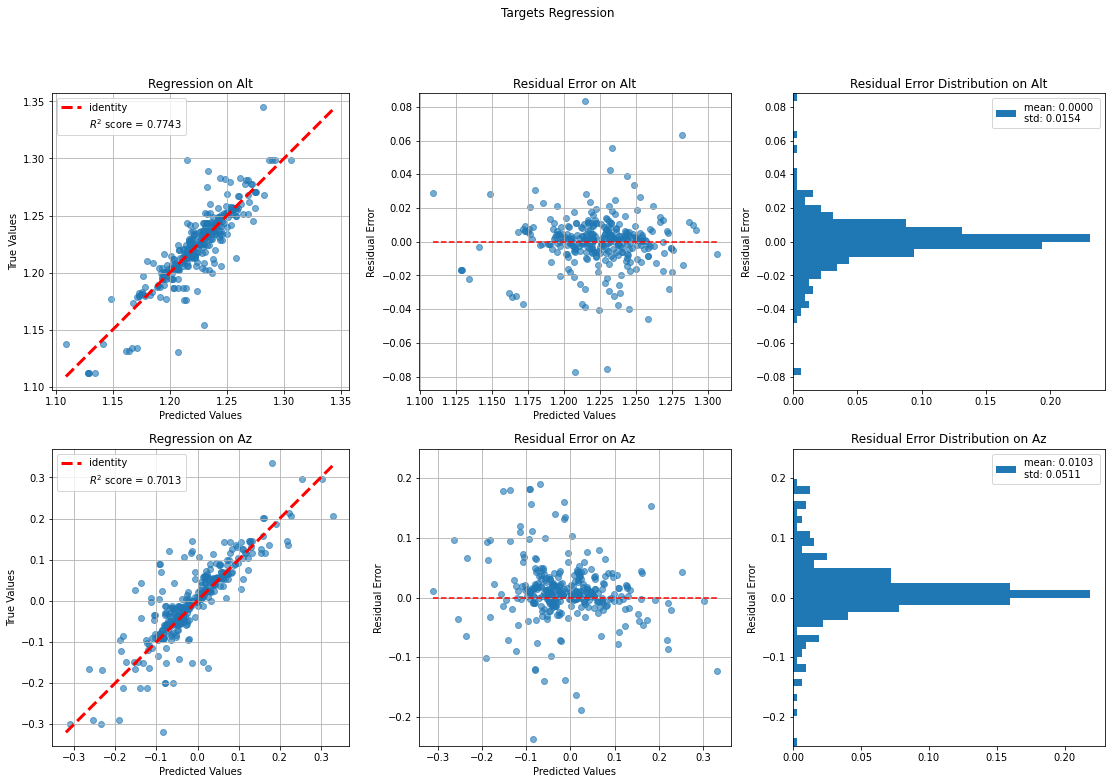

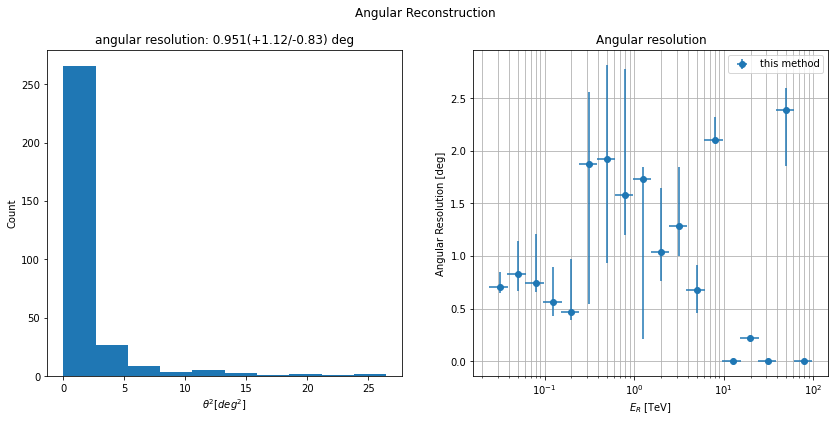

In [30]:
for telescope_i, results in models_results.items():
    display(HTML(f"<h3>{telescope_i}</h3>"))
    df_ = pd.DataFrame({
       "true_alt": results["targets"][:,0].flatten(),
       "true_az":  results["targets"][:,1].flatten(),
       "pred_alt": results["predictions"][:,0].flatten(),
       "pred_az": results["predictions"][:,1].flatten(),
       "true_mc_energy": results["true_energy"].flatten(),
    })
    df_ = df_.dropna()
    scores = r2_score(df_[["true_alt", "true_az"]], df_[["pred_alt", "pred_az"]], multioutput="raw_values")
    plot_regression_evaluation(df_, targets, scores)
    plot_error_and_angular_resolution(df_)

## Assembler Predictions


In [32]:
# Prepare targets points
targets_values = None
event_ids = None
true_energy = None
for _, t, meta in tqdm(sample_generator):
    event_ids = meta["event_id"] if event_ids is None else np.concatenate((event_ids, meta["event_id"]))
    true_energy = meta["true_energy"] if true_energy is None else np.concatenate((true_energy, meta["true_energy"]))
    targets_values = t if targets_values is None else np.concatenate((targets_values, t))
    
# Predictions
sample_generator.include_event_id = False
sample_generator.include_true_energy = False

predictions = umonna_assembler.predict(sample_generator)
predictions_points = umonna_assembler.predict_point(sample_generator)

sample_generator.include_event_id = True
sample_generator.include_true_energy = True

models_results["assembled"] = {
    "predictions": predictions_points, 
    "targets": targets_values, 
    "true_energy": true_energy, 
    "event_ids": event_ids
}

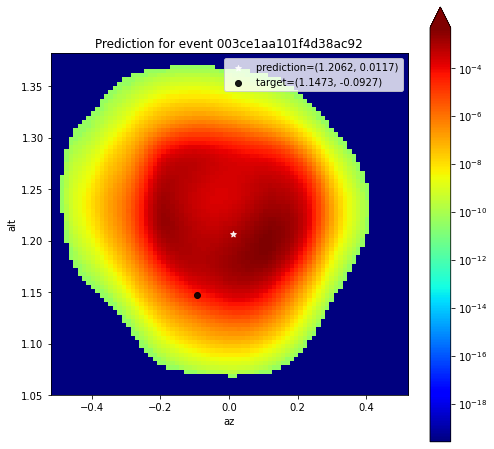

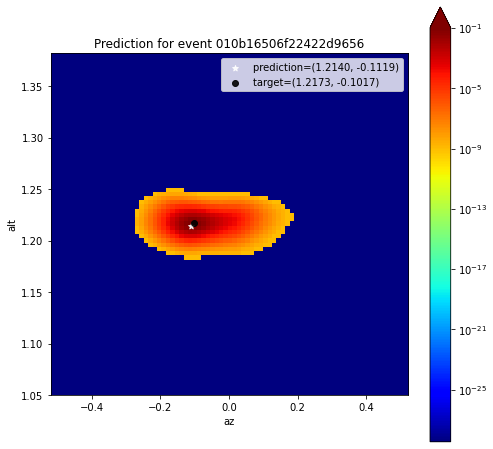

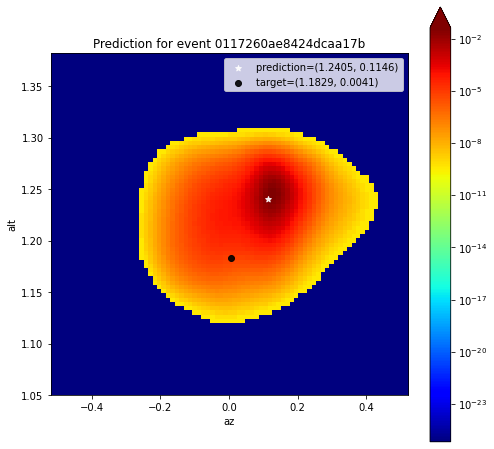

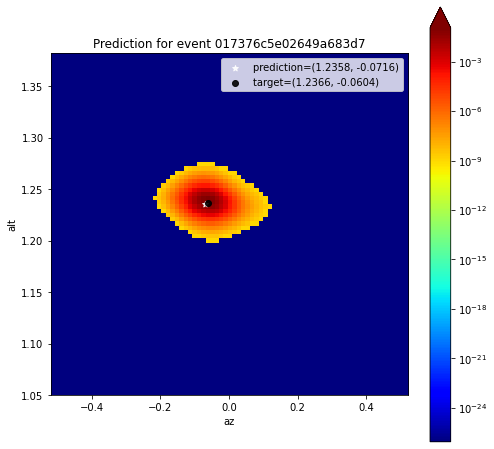

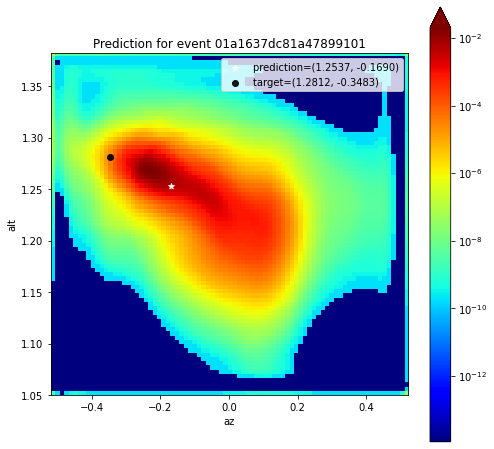

In [33]:
target_domains = umonna_assembler.target_domains
target_resolutions = umonna_assembler.target_resolutions
targets = umonna_assembler.targets

i = 0
for prediction, prediction_point, target_point, event_id in zip(predictions, predictions_points, targets_values, event_ids):
    plot_assembler_prediction(prediction, prediction_point, targets, target_domains, target_resolutions, event_id, target_point)
    i+=1
    if i == 5: break

## Assembler Evaluation

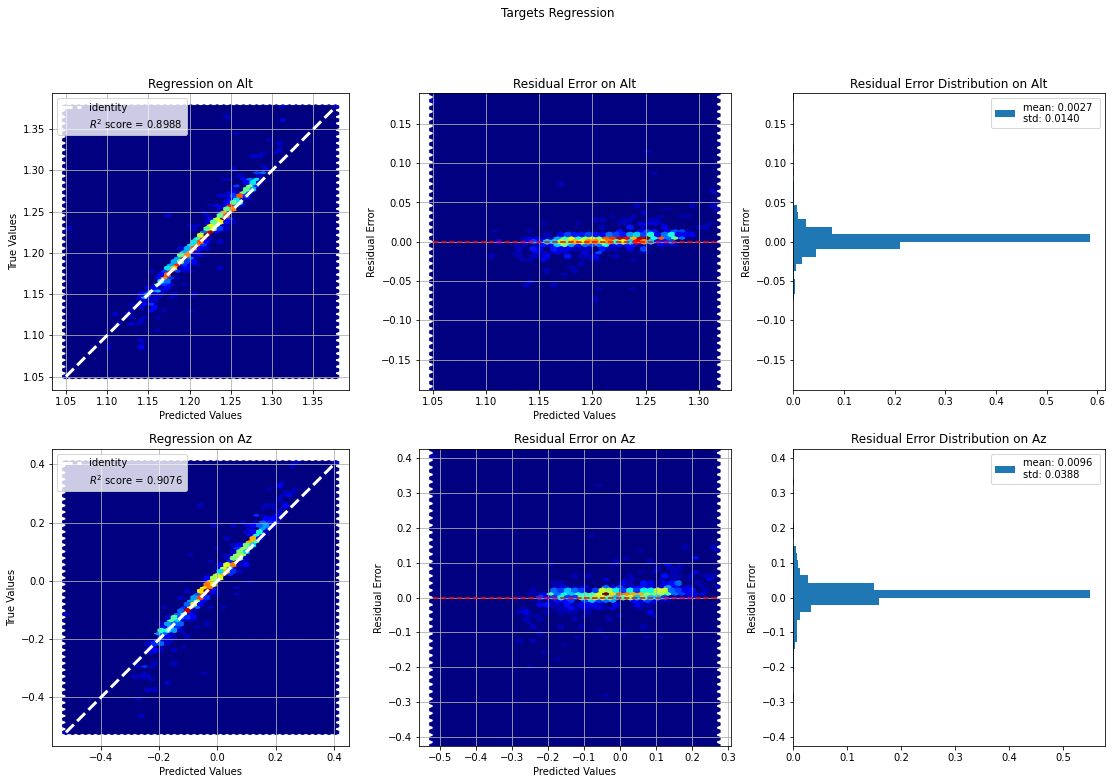

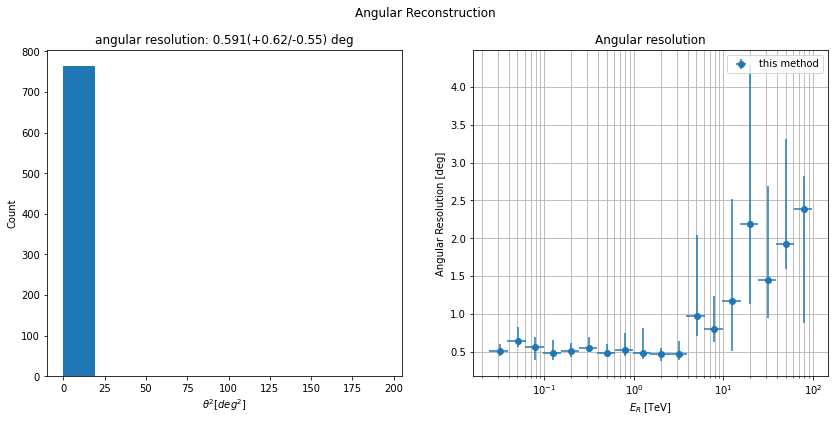

In [34]:
# TODO: fix evaluation
#sample_generator.include_event_id = False
#sample_generator.include_true_energy = False
#scores = umonna_assembler.evaluate(sample_generator, return_predictions=True)
#scores, df = umonna_assembler.evaluate(test_generator, return_predictions=True)
#sample_generator.include_event_id = True
#sample_generator.include_true_energy = True

results = models_results["assembled"]
display(HTML(f"<h3>Assembled</h3>"))
df_ = pd.DataFrame({
       "true_alt": results["targets"][:,0].flatten(),
       "true_az":  results["targets"][:,1].flatten(),
       "pred_alt": results["predictions"][:,0].flatten(),
       "pred_az": results["predictions"][:,1].flatten(),
       "true_mc_energy": results["true_energy"].flatten(),
})


df_ = df_.dropna()
scores = r2_score(df_[["true_alt", "true_az"]], df_[["pred_alt", "pred_az"]], multioutput="raw_values")
plot_regression_evaluation(df_, targets, scores)
plot_error_and_angular_resolution(df_)

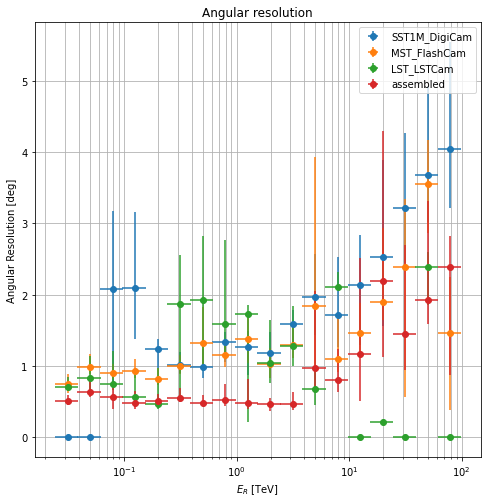

In [43]:
plot_angular_resolution_comparison(models_results)

In [0]:
df.to_csv("/content/drive/My Drive/Projects/gerumo/notebooks/evaluation_alt_az.csv")

# Energy Reconstruction


## Load Configuration file

In [6]:
config_file = "/content/drive/My Drive/Projects/gerumo/train/config/colab/energy/umonna_assembler_colab.json"

print(f"Loading config from: {config_file}")
with open(config_file) as cfg_file:
    config = json.load(cfg_file)

# Model
model_name = config["model_name"]

# Dataset Parameters
output_folder = config["output_folder"]
replace_folder_test = config["replace_folder_test"]
test_events_csv    = config["test_events_csv"]
test_telescope_csv = config["test_telescope_csv"]

# Input and Target Parameters 
telescopes = config["telescopes"]
min_observations = config["min_observations"]
input_image_mode = config["input_image_mode"]
input_image_mask = config["input_image_mask"]
input_features = config["input_features"]
targets = config["targets"]
target_mode = "lineal"
target_shapes = config["target_shapes"]
target_domains = config["target_domains"]
target_resolutions = get_resolution(targets, target_domains, target_shapes)

# Prepare Generator target_mode_config 
target_mode_config = {
    "target_shapes":      tuple([target_shapes[target]      for target in targets]),
    "target_domains":     tuple([target_domains[target]     for target in targets]),
    "target_resolutions": tuple([target_resolutions[target] for target in targets])
}
if target_mode == "probability_map":
    target_sigmas = config["target_sigmas"]
    target_mode_config["target_sigmas"] = tuple([target_sigmas[target] for target in targets])

# Evaluation Parameters
save_plots = config["save_plots"]
save_predictions = config["save_predictions"]

Loading config from: /content/drive/My Drive/Projects/gerumo/train/config/colab/energy/umonna_assembler_colab.json


In [7]:
pprint.pprint(config, width=1)

{'input_features': ['x',
                    'y'],
 'input_image_mask': True,
 'input_image_mode': 'simple-shift',
 'min_observations': [0,
                      0,
                      0],
 'model_name': 'UMONNA_V2_ENERGY',
 'output_folder': '/content/drive/Shared '
                  'drives/umonna/data/output',
 'replace_folder_test': '/content/drive/Shared '
                        'drives/umonna/data/data/raw/Test',
 'save_plots': True,
 'save_predictions': True,
 'target_domains': {'alt': [1.05,
                            1.382],
                    'az': [-0.52,
                           0.52],
                    'log10_mc_energy': [-2.351,
                                        2.47]},
 'target_mode': 'lineal',
 'target_shapes': {'alt': 81,
                   'az': 81,
                   'log10_mc_energy': 81},
 'target_sigmas': {'alt': 0.002,
                   'az': 0.002,
                   'log10_mc_energy': 0.002},
 'targets': ['log10_mc_energy'],
 'telescopes': {'LST_

## Load Dataset

In [0]:
# Prepare datasets
test_dataset = load_dataset(test_events_csv, test_telescope_csv, replace_folder_test)
test_dataset = aggregate_dataset(test_dataset, az=True, log10_mc_energy=True)
test_dataset = filter_dataset(test_dataset, telescopes, min_observations, target_domains)

# Preprocessing pipes
preprocess_input_pipes = []
preprocess_output_pipes = []

## Data Generator

In [0]:
# Generators
batch_size = 64
telescope_types = [t for t in telescopes.keys() if telescopes[t] is not None]
test_generator = AssemblerGenerator(test_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode=target_mode, 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

# Small test sample
sample_events = np.random.choice(test_dataset.event_unique_id.unique(), 3*256)
sample_dataset = test_dataset[test_dataset.event_unique_id.isin(sample_events)]

sample_generator = AssemblerGenerator(sample_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode="lineal", 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True,
                                    include_true_energy=True
)

### Generator sample

In [10]:
# Debug: Check if test dataset is loadable
#for i in tqdm(range(len(test_generator))):
#  _ = test_generator[i]

# Debug: Check if sample dataset is loadable
for i in tqdm(range(len(sample_generator))):
    _ = sample_generator[i]

## Load Models

In [11]:
sst = telescopes["SST1M_DigiCam"]
mst = telescopes["MST_FlashCam"]
lst = telescopes["LST_LSTCam"]
telescopes
pprint.pprint(telescopes, width=1)

{'LST_LSTCam': '/content/drive/Shared '
               'drives/umonna/data/models/energy/small/UMONNA_UNIT_LST_V2_ENERGY_LST_LSTCam_crossentropy_e010_3.1496.h5',
 'MST_FlashCam': '/content/drive/Shared '
                 'drives/umonna/data/models/energy/small/UMONNA_UNIT_MST_V2_ENERGY_MST_FlashCam_crossentropy_e015_3.4590.h5',
 'SST1M_DigiCam': '/content/drive/Shared '
                  'drives/umonna/data/models/energy/small/UMONNA_UNIT_SST_V2_ENERGY_SST1M_DigiCam_crossentropy_e004_3.3022.h5'}


In [12]:
umonna_assembler = Umonna(sst1m_model_or_path=sst,
                mst_model_or_path=mst,
                lst_model_or_path=lst,
                targets=targets, target_shapes=target_mode_config["target_shapes"],
                target_domains=target_mode_config["target_domains"],
                target_resolutions=target_mode_config["target_resolutions"],
                assembler_mode="normalized_product",
                point_estimation_mode="expected_value"
)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Model Unit Predictions


In [0]:
target_domains_ = target_domains if isinstance(target_domains, dict) else target_domains_
targets = umonna_assembler.targets
models_results = {}

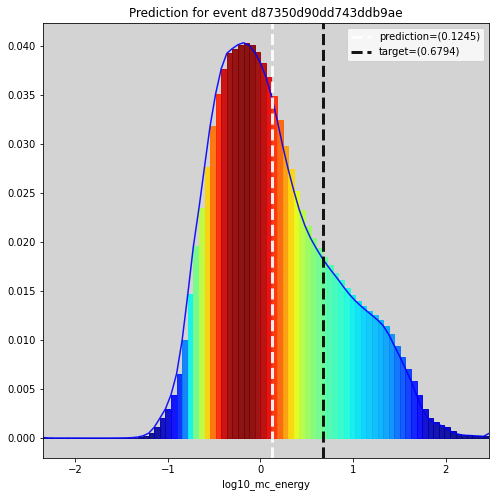

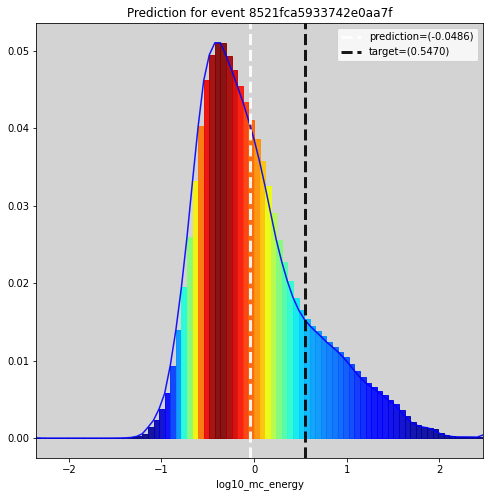

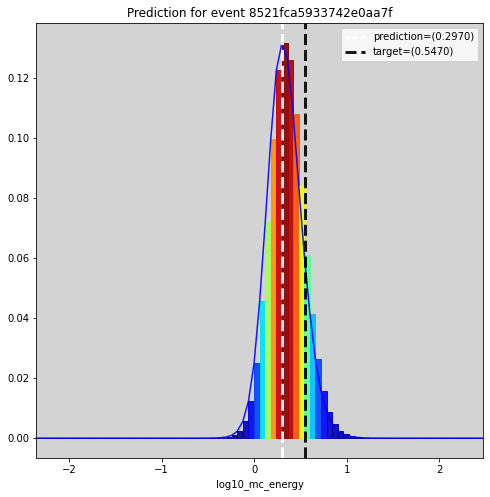

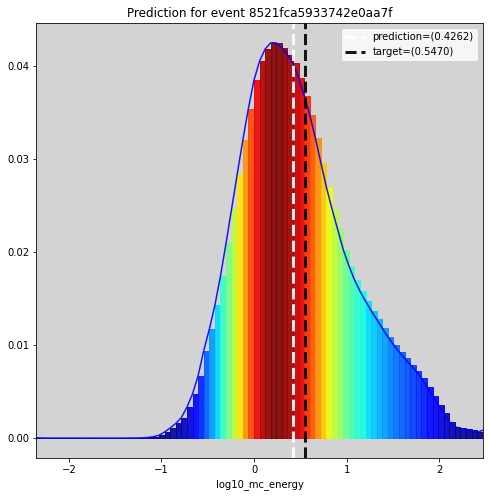

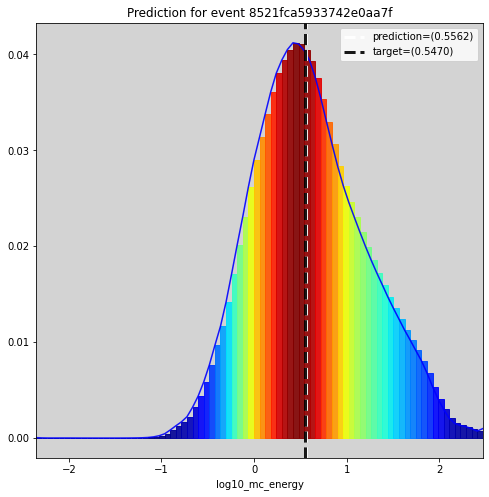

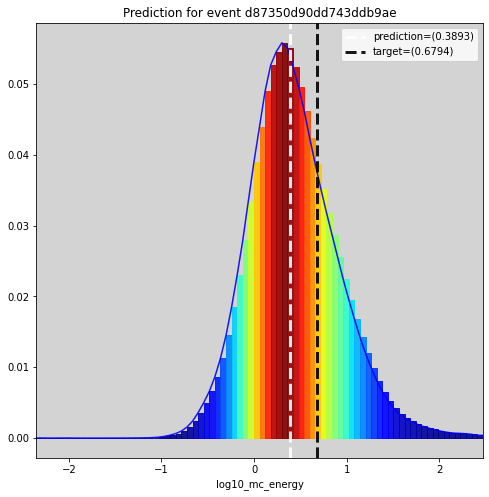

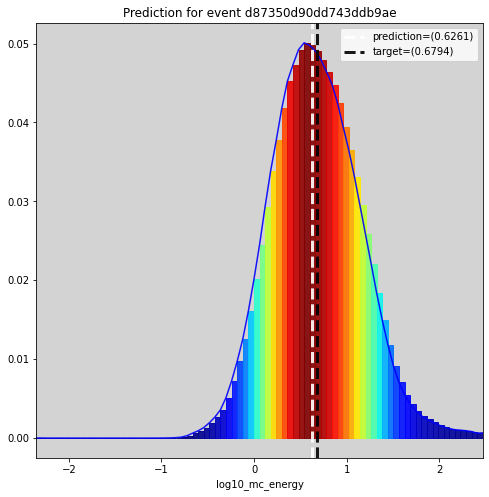

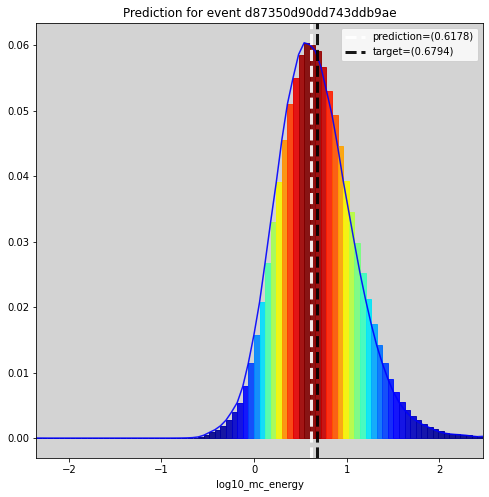

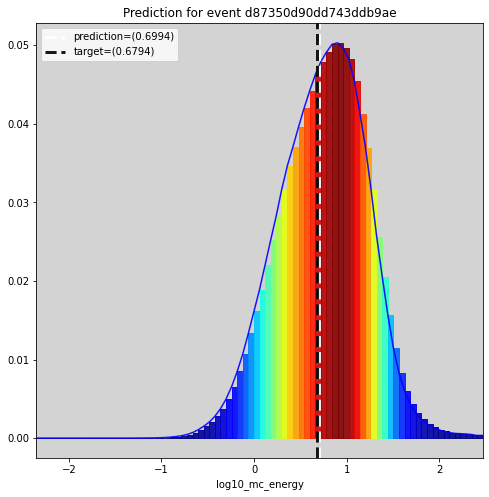

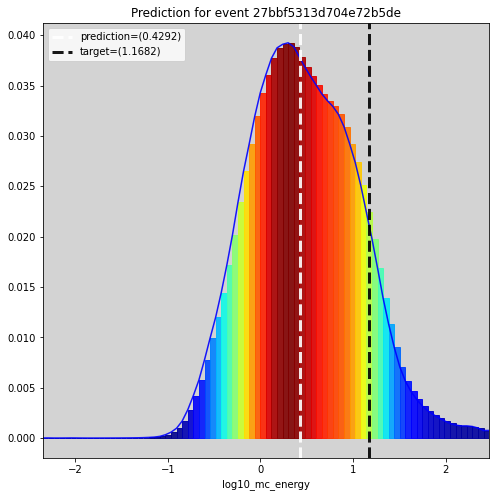

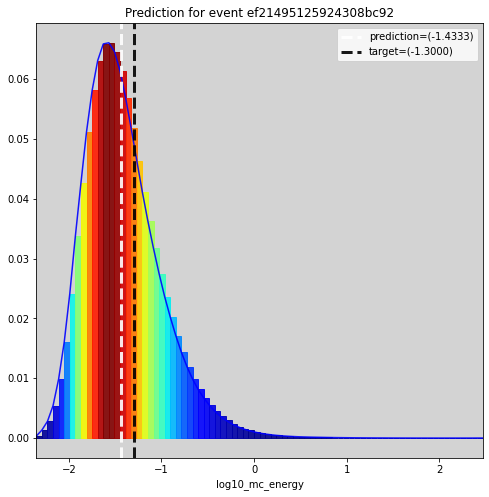

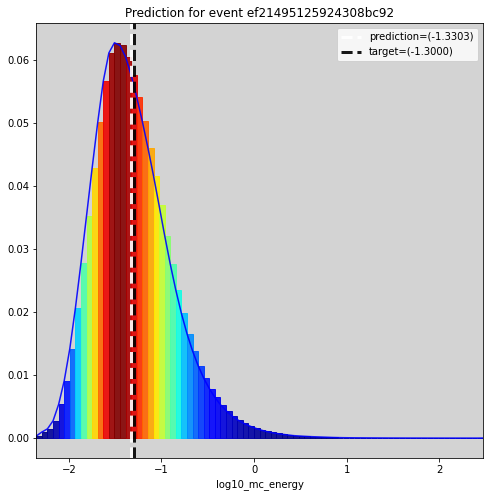

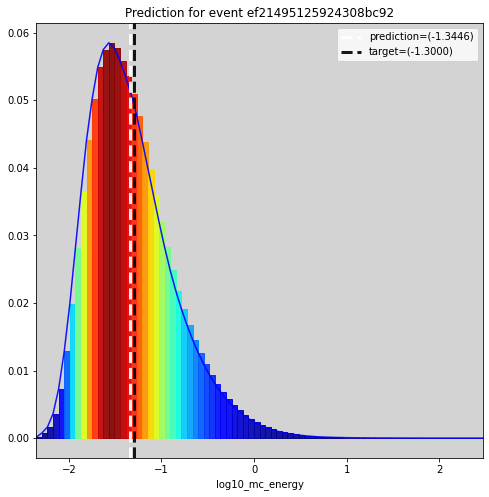

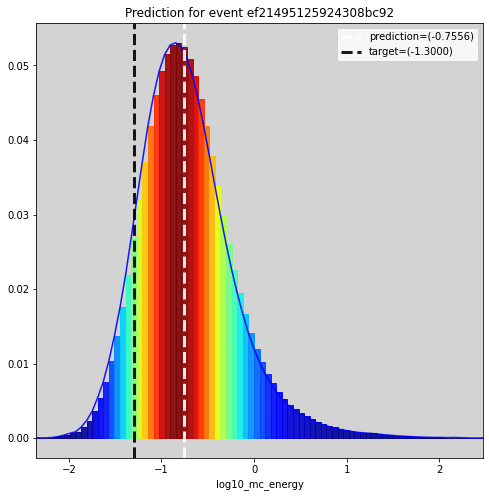

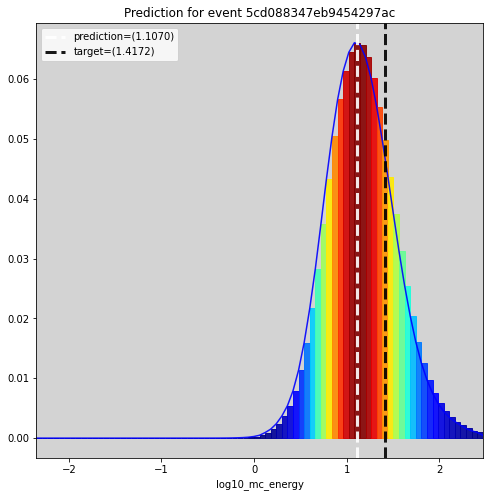

In [14]:
for telescope_i, model in umonna_assembler.models.items():
    display(HTML(f"<h3>{telescope_i}</h3>"))
    # Telescope Sample Dataset
    sample_dataset_telescope = filter_dataset(sample_dataset, [telescope_i], min_observations, target_domains)
    telescope_generator = AssemblerUnitGenerator(sample_dataset_telescope, batch_size, 
                                            input_image_mode=input_image_mode, 
                                            input_image_mask=input_image_mask, 
                                            input_features=input_features,
                                            targets=targets,
                                            target_mode="lineal",
                                            target_mode_config=target_mode_config,
                                            preprocess_input_pipes=preprocess_input_pipes,
                                            preprocess_output_pipes=preprocess_output_pipes,
                                            include_event_id=True,
                                            include_true_energy=True
                                            )
    # Prepare targets points
    targets_values = None
    event_ids = None
    true_energy = None
    predictions = None
    predictions_points = None
    for x, t, meta in tqdm(telescope_generator):
        event_ids = meta["event_id"] if event_ids is None else np.concatenate((event_ids, meta["event_id"]))
        true_energy = meta["true_energy"] if true_energy is None else np.concatenate((true_energy, meta["true_energy"]))
        targets_values = t if targets_values is None else np.concatenate((targets_values, t))
        # Predictions
        p = model.predict(x)
        p_points = umonna_assembler.point_estimation(p)
        predictions = p if predictions is None else  np.concatenate((predictions, p))
        predictions_points = p_points if predictions_points is None else np.concatenate((predictions_points, p_points))

    models_results[telescope_i] = {"predictions": predictions_points, "targets": targets_values, "true_energy": true_energy, "event_ids": event_ids}

    # Show Predictions
    i = 0
    for prediction, prediction_point, target_point, event_id in zip(predictions, predictions_points, targets_values, event_ids):
        plot_assembler_prediction(prediction, prediction_point, targets, umonna_assembler.target_domains, umonna_assembler.target_resolutions, event_id, target_point)
        i+=1
        if i == 5: break

## Model Unit Evaluation


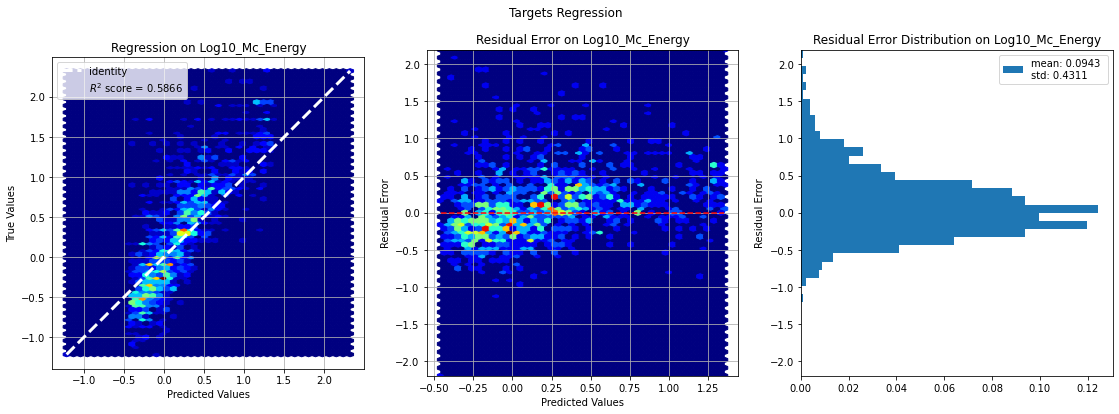

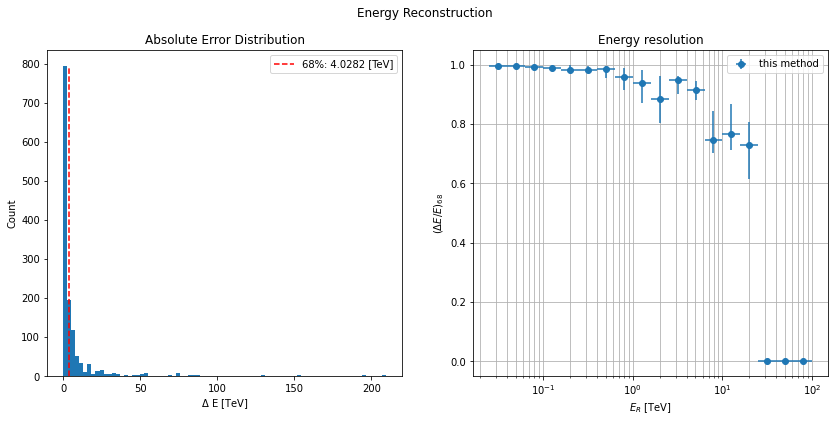

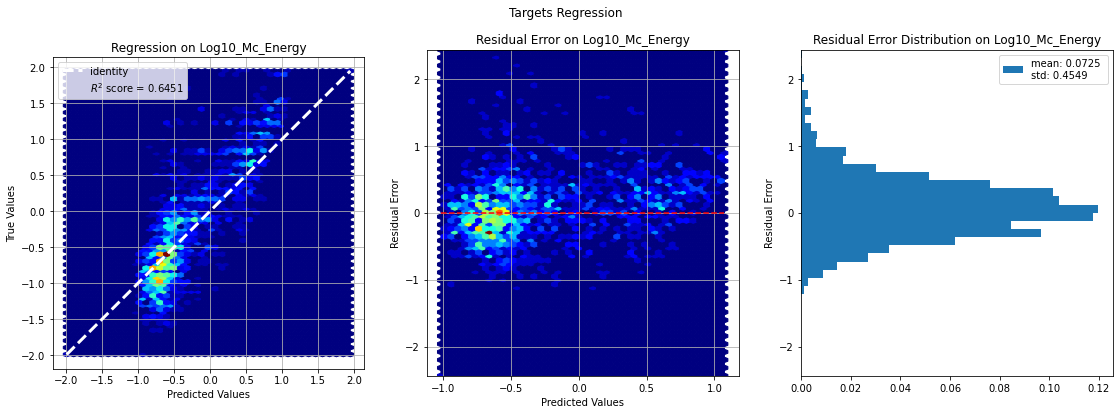

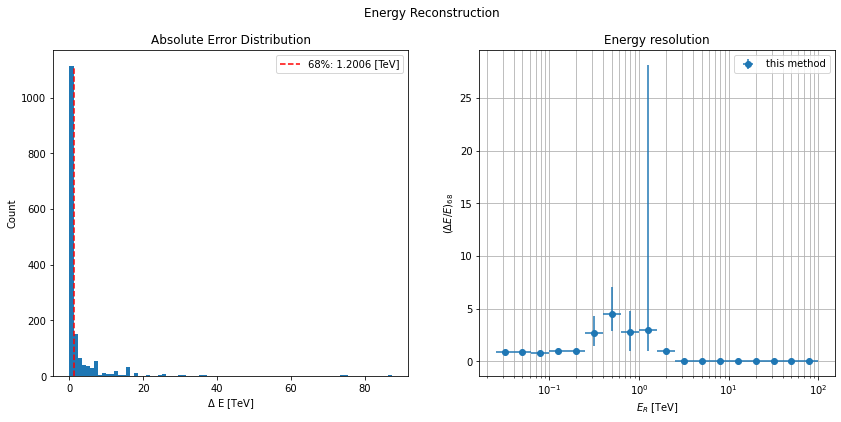

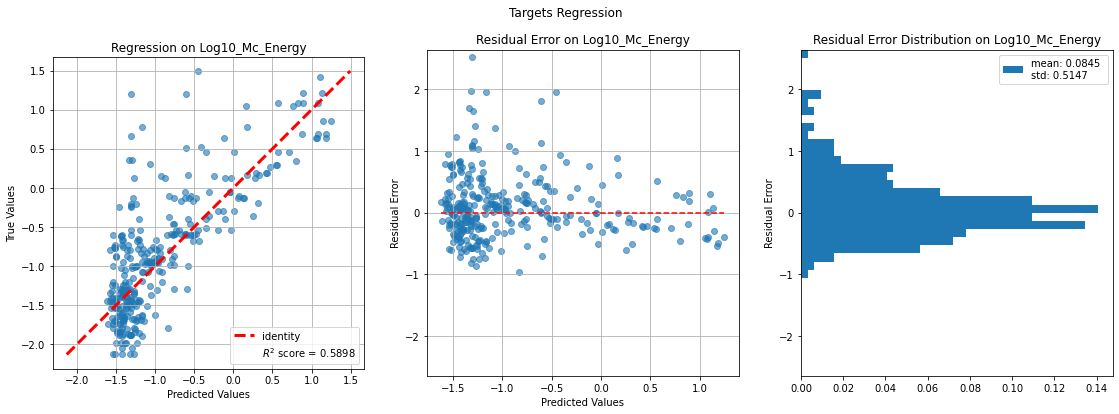

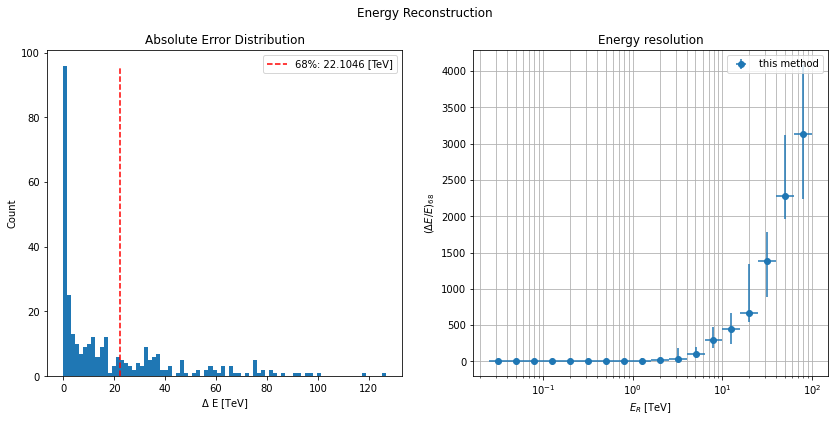

In [15]:
for telescope_i, results in models_results.items():
    display(HTML(f"<h3>{telescope_i}</h3>"))
    df_ = pd.DataFrame({
      "true_log10_mc_energy": results["targets"].flatten(),
       "pred_log10_mc_energy": results["predictions"].flatten(),
        "true_mc_energy": results["true_energy"].flatten(),
    })
    df_ = df_.dropna()
    scores = r2_score(df_[["true_log10_mc_energy"]], df_[["pred_log10_mc_energy"]], multioutput="raw_values")
    plot_regression_evaluation(df_, targets, scores)
    plot_error_and_energy_resolution(df_)

## Assembler Predictions


In [16]:
# Prepare targets points
targets_values = None
event_ids = None
true_energy = None
for _, t, meta in tqdm(sample_generator):
    event_ids = meta["event_id"] if event_ids is None else np.concatenate((event_ids, meta["event_id"]))
    true_energy = meta["true_energy"] if true_energy is None else np.concatenate((true_energy, meta["true_energy"]))
    targets_values = t if targets_values is None else np.concatenate((targets_values, t))
    
# Predictions
sample_generator.include_event_id = False
sample_generator.include_true_energy = False

predictions = umonna_assembler.predict(sample_generator)
predictions_points = umonna_assembler.predict_point(sample_generator)

sample_generator.include_event_id = True
sample_generator.include_true_energy = True

models_results["assembled"] = {
    "predictions": predictions_points, 
    "targets": targets_values, 
    "true_energy": true_energy, 
    "event_ids": event_ids
}

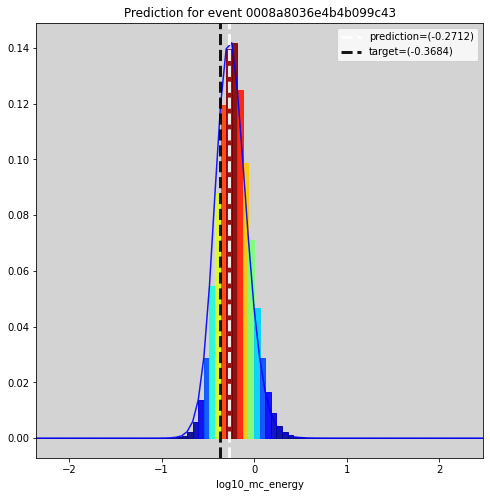

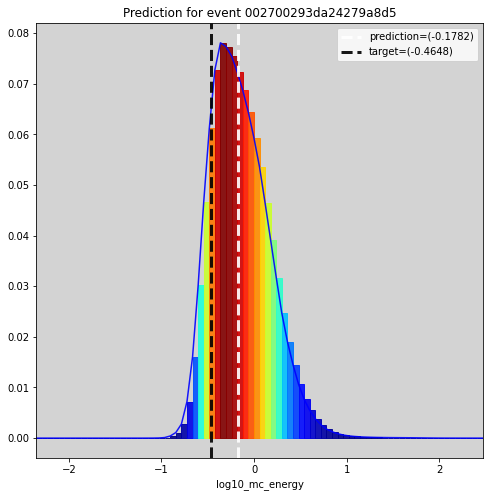

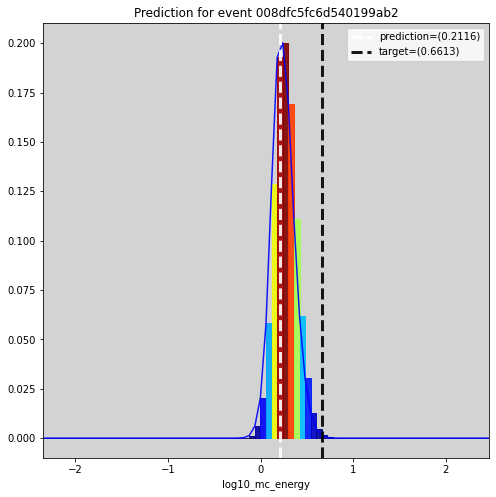

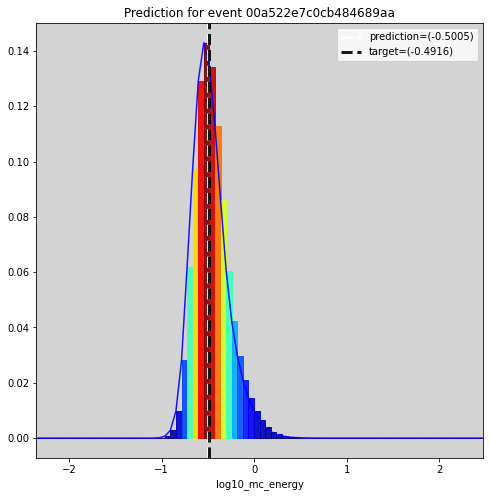

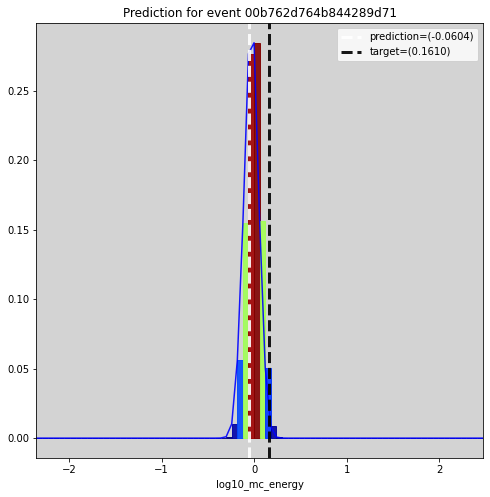

In [17]:
target_domains = umonna_assembler.target_domains
target_resolutions = umonna_assembler.target_resolutions
targets = umonna_assembler.targets

i = 0
for prediction, prediction_point, target_point, event_id in zip(predictions, predictions_points, targets_values, event_ids):
    plot_assembler_prediction(prediction, prediction_point, targets, target_domains, target_resolutions, event_id, target_point)
    i+=1
    if i == 5: break

## Assembler Evaluation

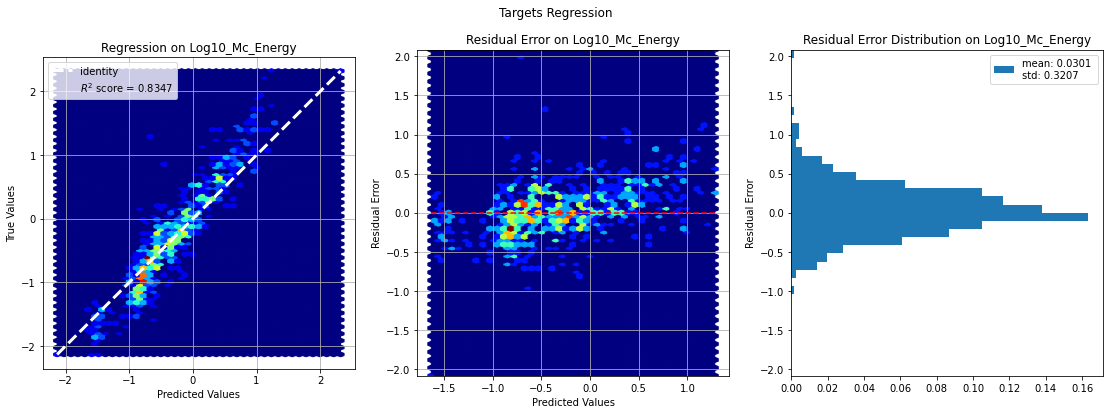

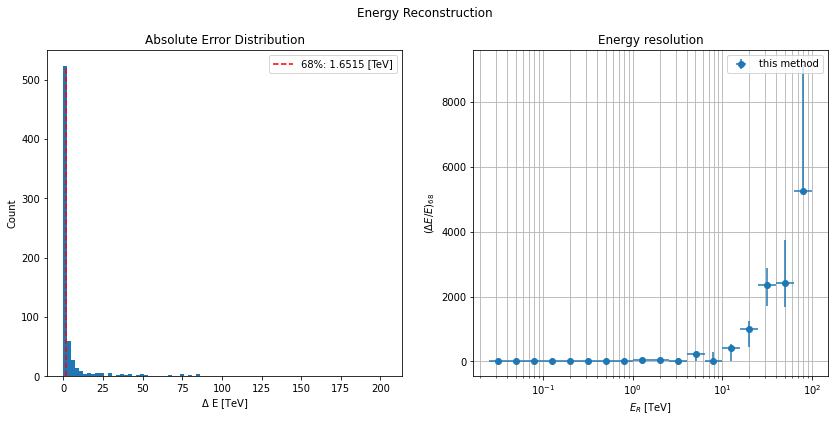

In [18]:
# TODO: fix evaluation
#sample_generator.include_event_id = False
#sample_generator.include_true_energy = False
#scores = umonna_assembler.evaluate(sample_generator, return_predictions=True)
#scores, df = umonna_assembler.evaluate(test_generator, return_predictions=True)
#sample_generator.include_event_id = True
#sample_generator.include_true_energy = True

results = models_results["assembled"]
display(HTML(f"<h3>Assembled</h3>"))
df_ = pd.DataFrame({
    "true_log10_mc_energy": results["targets"].flatten(),
    "pred_log10_mc_energy": results["predictions"].flatten(),
    "true_mc_energy": results["true_energy"].flatten(),
})

df_ = df_.dropna()
#scores = r2_score(df_[["true_alt", "true_az"]], df_[["pred_alt", "pred_az"]], multioutput="raw_values")
scores = r2_score(df_[["true_log10_mc_energy"]], df_[["pred_log10_mc_energy"]], multioutput="raw_values")
plot_regression_evaluation(df_, targets, scores)

plot_error_and_energy_resolution(df_)

* calcular incertidumbre
* ajustar una gaussiana y extraer ancho (sigma)
* error relativo

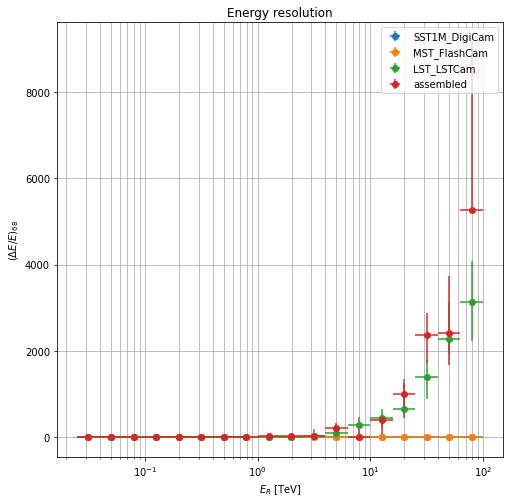

In [19]:
plot_energy_resolution_comparison(models_results)

In [0]:
df.to_csv("/content/drive/My Drive/Projects/gerumo/notebooks/evaluation_energy.csv")

In [0]:
import gerumo
import imp
imp.reload(gerumo.generator)
from gerumo.data.generator import *

In [0]:
import ctaplot
import matplotlib.pyplot as plt

def show_energy_resolution(predicted_mc_energy, true_mc_energy, 
                           percentile=68.27, confidence_level=0.95, bias_correction=False,
                           label="this method", include_requirement=[], xlim=None, ylim=None, ax=None):
    # Create new figure
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()

    ax = ctaplot.plot_energy_resolution(true_mc_energy, predicted_mc_energy,
                                percentile, confidence_level, bias_correction, ax,
                                marker='o', label=label)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend()

    try:
        for include in include_requirement:
            ax = ctaplot.plot_energy_resolution_cta_requirement(include, ax)
    except:
        pass
    return ax

def show_absolute_error_energy(predicted_mc_energy, true_mc_energy, bins=60, percentile_plot_range=80,ax=None):
    # Create new figure
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()

    absolute_error = np.abs(predicted_mc_energy - true_mc_energy)
    
    x_max = np.percentile(absolute_error, 100)
    hist = ax.hist(absolute_error, bins=bins, range=(0, x_max))
    y_max = hist[0].max()

    sig_68 = np.percentile(absolute_error, 68.27)
    sig_95 = np.percentile(absolute_error, 95.45)
    sig_99 = np.percentile(absolute_error, 99.73)

    if percentile_plot_range >= 68:
        ax.vlines(sig_68, 0, y_max, label=f'68%: {sig_68:.4f} [TeV]', linestyle="--", color='red')
    if percentile_plot_range >= 95:
        ax.vlines(sig_95, 0, y_max, label=f'95%: {sig_95:.4f} [TeV]', linestyle="--", color='green')
    if percentile_plot_range >= 99:
        ax.vlines(sig_99, 0, y_max, label=f'99%: {sig_99:.4f} [TeV]', linestyle="--", color='yellow')

    # Style
    ax.set_title(f"Absolute Error Distribution")
    
    ax.set_aspect("auto")

    ax.set_ylabel("Count")
    ax.set_xlabel("$\Delta$ E [TeV]")
    ax.legend()
    return ax

def plot_error_and_energy_resolution(evaluation_results, bins=80, include_requirement=[], 
                                     percentile=68.27, confidence_level=0.95, bias_correction=False,
                                     percentile_plot_range=80, label="this method", xlim=None, ylim=None,
                                     save_to=None):
    
    predicted_mc_energy = evaluation_results["pred_log10_mc_energy"].apply(lambda log_e: np.power(log_e, 10))
    true_mc_energy = evaluation_results["true_mc_energy"]

    # Create Figure and axis
    fig, axis = plt.subplots(1, 2, figsize=(14, 6))
    
    # Style
    plt.suptitle("Energy Reconstruction")

    # Generate two plots
    show_absolute_error_energy(predicted_mc_energy, true_mc_energy, bins=bins, 
                               percentile_plot_range=percentile_plot_range, ax=axis[0])
    show_energy_resolution(predicted_mc_energy, true_mc_energy, percentile, confidence_level,
                           bias_correction, label, include_requirement, xlim, ylim,
                           ax=axis[1])
    
    # Save or Show
    if save_to is not None:
        plt.savefig(save_to)
    else:
        plt.show()

def plot_energy_resolution_comparison(evaluation_results_dict, include_requirement=[], 
                                     percentile=68.27, confidence_level=0.95, bias_correction=False,
                                     percentile_plot_range=80, xlim=None, ylim=None, save_to=None):
    # Create Figure and axis
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    plt.title("Energy Resolution Comparison")
    for label, results in evaluation_results_dict.items():
        predicted_mc_energy = np.power(results["predictions"].flatten(), 10)
        true_mc_energy = results["true_energy"].flatten()
        show_energy_resolution(predicted_mc_energy, true_mc_energy, 
                           percentile, confidence_level, bias_correction,
                           label, [], xlim, ylim, ax)
        
    try:
        for include in include_requirement:
            ax = ctaplot.plot_energy_resolution_cta_requirement(include, ax)
    except:
        pass

    # Save or Show
    if save_to is not None:
        plt.savefig(save_to)
    else:
        plt.show()
    
def show_angular_resolution(predicted_alt, predicted_az, true_alt, true_az, true_mc_energy,
                           percentile=68.27, confidence_level=0.95, bias_correction=False,
                           label="this method", include_requirement=[], xlim=None, ylim=None, ax=None):
    # Create new figure
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()

    ax = ctaplot.plot_angular_resolution_per_energy(predicted_alt, predicted_az, true_alt, true_az, true_mc_energy,
                                percentile, confidence_level, bias_correction, ax,
                                marker='o', label=label)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend()

    try:
        for include in include_requirement:
            ax = ctaplot.plot_energy_resolution_cta_requirement(include, ax)
    except:
        pass
    return ax

def show_absolute_error_angular(predicted_alt, predicted_az, true_alt, true_az, bias_correction=False, 
                                ax=None, bins=40, percentile_plot_range=80):
    # Create new figure
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()
    
    #ax = ctaplot.plot_theta2(predicted_alt, predicted_az, true_alt, true_az, bias_correction, ax, range=(0, percentile_plot_range), bins=bins)
    ax = ctaplot.plot_theta2(predicted_alt, predicted_az, true_alt, true_az, bias_correction, ax)
    return ax

def plot_error_and_angular_resolution(evaluation_results, bins=80, include_requirement=[], 
                                     percentile=68.27, confidence_level=0.95, bias_correction=False,
                                     percentile_plot_range=80, label="this method", xlim=None, ylim=None,
                                     save_to=None):
    predicted_alt = evaluation_results["pred_alt"]
    predicted_az = evaluation_results["pred_az"]

    true_alt = evaluation_results["true_alt"]
    true_az = evaluation_results["true_az"]

    true_mc_energy = evaluation_results["true_mc_energy"]

    # Create Figure and axis
    fig, axis = plt.subplots(1, 2, figsize=(14, 6))
    
    # Style
    plt.suptitle("Angular Reconstruction")

    # Generate two plots
    show_absolute_error_angular(predicted_alt, predicted_az, true_alt, true_az, bias_correction, axis[0], bins, 
                               percentile_plot_range)
    show_angular_resolution(predicted_alt, predicted_az, true_alt, true_az, true_mc_energy,
                            percentile, confidence_level, bias_correction, label, include_requirement, xlim, ylim,
                           ax=axis[1])
    
    # Save or Show
    if save_to is not None:
        plt.savefig(save_to)
    else:
        plt.show()

def plot_angular_resolution_comparison(evaluation_results_dict, include_requirement=[], 
                                     percentile=68.27, confidence_level=0.95, bias_correction=False,
                                     percentile_plot_range=80, xlim=None, ylim=None, save_to=None):
    # Create Figure and axis
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    plt.title("Angular Resolution Comparison")
    for label, results in evaluation_results_dict.items():

        results = df_ = pd.DataFrame({
              "true_alt": results["targets"][:,0].flatten(),
              "true_az":  results["targets"][:,1].flatten(),
              "pred_alt": results["predictions"][:,0].flatten(),
              "pred_az": results["predictions"][:,1].flatten(),
              "true_mc_energy": results["true_energy"].flatten(),
        })

        predicted_alt = results["pred_alt"]
        predicted_az = results["pred_az"]

        true_alt = results["true_alt"]
        true_az = results["true_az"]
        
        true_mc_energy = results["true_mc_energy"]
        show_angular_resolution(predicted_alt, predicted_az, true_alt, true_az, true_mc_energy,
                           percentile, confidence_level, bias_correction,
                           label, [], xlim, ylim, ax)
        
    try:
        for include in include_requirement:
            ax = ctaplot.plot_angular_resolution_cta_requirement(include, ax)
    except:
        pass

    # Save or Show
    if save_to is not None:
        plt.savefig(save_to)
    else:
        plt.show()

In [41]:
models_results["assembled"].keys()

dict_keys(['predictions', 'targets', 'true_energy', 'event_ids'])